Lines 1 shape: (10, 10, 2) Lines 2 shape: (10, 10, 2)
After intersection - Lines 1 shape: 10 Lines 2 shape: 10


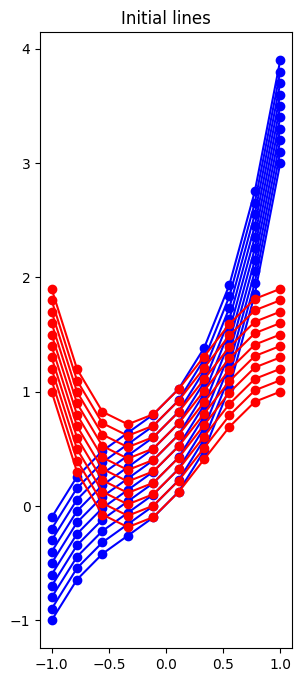

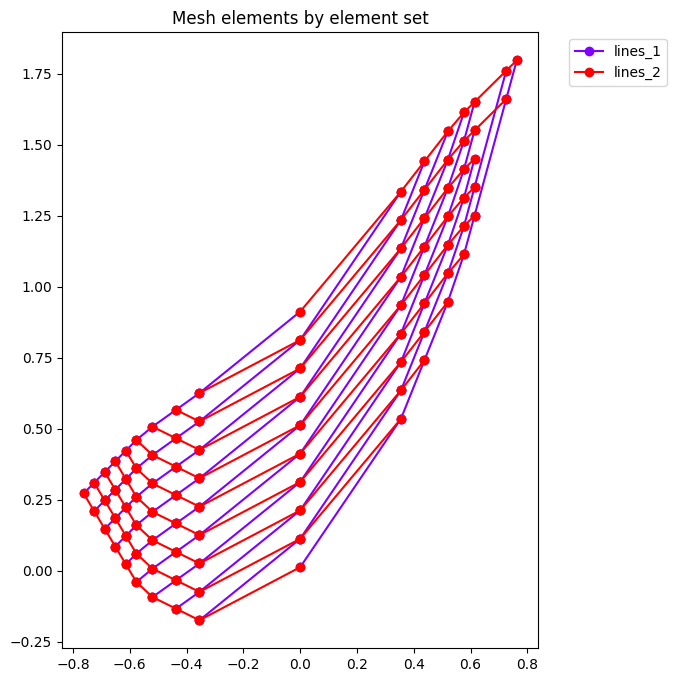

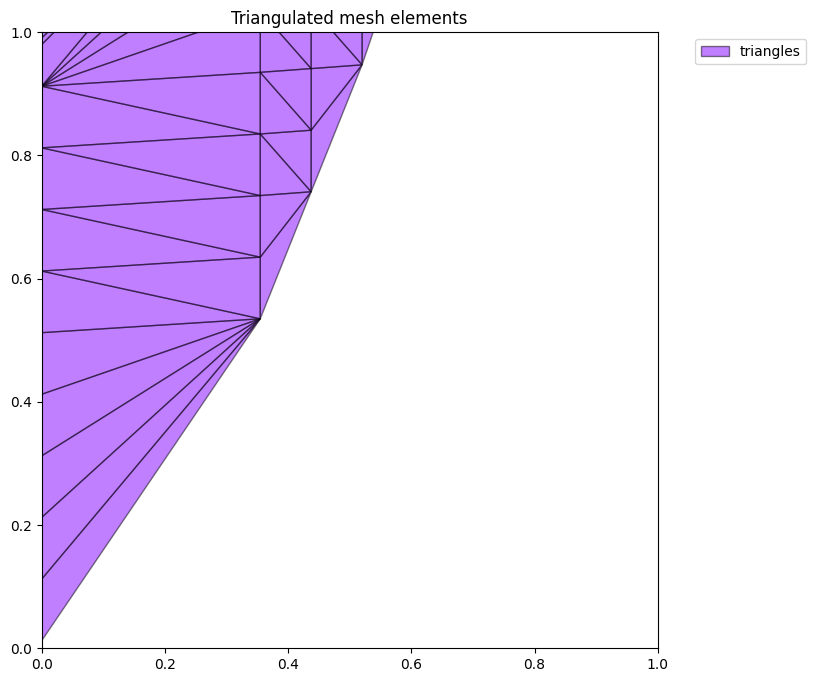

In [ ]:

from matplotlib import lines
import numpy as np
import Utils
from Tailoring import Lattice, Mesh, Set
import matplotlib.pyplot as plt
%matplotlib inline

### Edits made on 2024-06-10

# parabolas
def coord(x, sign, offset):
	return np.c_[x, sign*x**3 + x**2 + x + offset]

# lines
num_lines = 10
x = np.linspace(-1, 1, num_lines)
lines_1 = np.concatenate([coord(x, 1, offset/num_lines)[np.newaxis,...] for offset in range (num_lines)], axis=0)
lines_2 = np.concatenate([coord(x, -1, offset/num_lines)[np.newaxis,...] for offset in range (num_lines)], axis=0)
print("Lines 1 shape:", lines_1.shape, "Lines 2 shape:", lines_2.shape)

# plot: lines
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Initial lines")
ax.set_aspect('equal')
for line in lines_1:
    ax.plot(line[:,0], line[:,1], color='blue', marker='o')
for line in lines_2:
    ax.plot(line[:,0], line[:,1], color='red', marker='o')

# intersecting lines
lines_1, lines_2 = Lattice.resample_lines(lines_1, lines_2)
print("After intersection - Lines 1 shape:", len(lines_1), "Lines 2 shape:", len(lines_2))

# create mesh
mesh_2D = Mesh(2, 2)
mesh_2D.add_lines_to_mesh(lines_1, "lines_1")
mesh_2D.add_lines_to_mesh(lines_2, "lines_2")

# plot mesh: elements
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Mesh elements by element set")
ax.set_aspect('equal')
elsets = mesh_2D.elsets()
colours = plt.cm.rainbow(np.linspace(0,1,len(elsets)))
for (name, elset), colour in zip(elsets.items(), colours):
    for count, element in enumerate(elset):
        nodes = mesh_2D.elements[element]
        ax.plot(mesh_2D.nodes[nodes, 0], mesh_2D.nodes[nodes, 1], color=colour, marker='o', label=name if count==0 else None)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# triangulate mesh
mesh_2D_tri = Mesh(2,3)
for name, nset in mesh_2D.nsets().items():
    mesh_2D_tri.add_nodes(mesh_2D.nodes[nset], name)
mesh_2D_tri.triangulate(np.arange(mesh_2D_tri.nodes.shape[0]))

# plot mesh: elements
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Triangulated mesh elements")
ax.set_aspect('equal')
elsets = mesh_2D_tri.elsets()
colours = plt.cm.rainbow(np.linspace(0,1,len(elsets)))
for (name, elset), colour in zip(elsets.items(), colours):
    for count, element in enumerate(elset):
        nodes = mesh_2D_tri.elements[element]
        triangle = plt.Polygon(mesh_2D_tri.nodes[nodes], closed=True, facecolor=colour, edgecolor='k', alpha=0.5, label=name if count==0 else None)
        ax.add_patch(triangle)  
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.set_xlim([-1.5, 1.5])
# ax.set_ylim([-0.5, 2.5])



In [ ]:
from Mesh import Mesh
import Utils
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

lattice_lines = Utils.ReadWriteOps.load_object(
    os.path.join("test_case_7", "data", "0_lattice_lines"),
    method="pickle"
)

# Create 2D mesh for each increment
mesh2D = {}
for increment_key, grouped_lines in lattice_lines.items():
    mesh2D[increment_key] = Mesh(2, [2,3])

    # Create nodes and groups from lines
    for group_name, group_lines in grouped_lines.items():

        print("Processing group:", group_name, "with", len(group_lines), "lines, type:", type(group_lines))

        mesh_size = 0.01
        num_workers = max((os.cpu_count() - 2, 1))
        args = [(line, mesh_size) for line in group_lines]
        with ThreadPoolExecutor(num_workers) as executor:
            group_lines = list(executor.map(lambda ab: Utils.GeoOps.increment_line(*ab), args))

        mesh2D[increment_key].add_lines_to_mesh(0, group_lines, group_name)

Processing group: CHEVRONS with 68 lines, type: <class 'list'>
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39, 2) CHEVRONS
Adding line to mesh: (39,

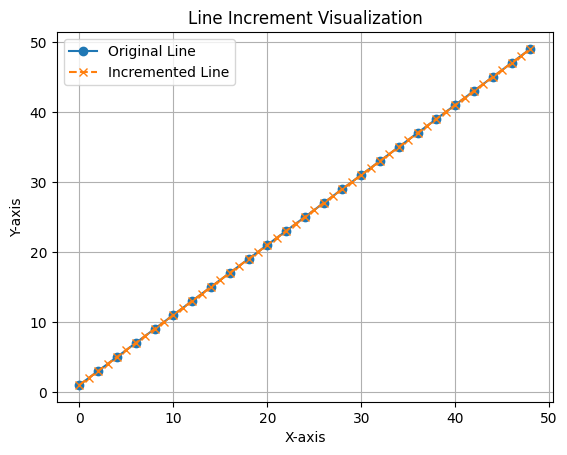

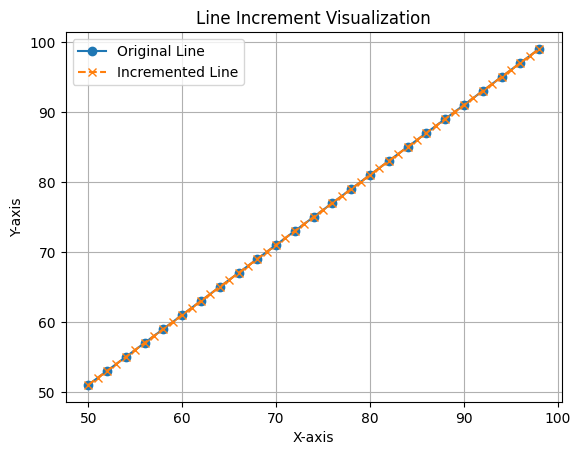

In [2]:

import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor
import Utils
import matplotlib.pyplot as plt
%matplotlib inline

def increment_line(line, increment_size):
    """
    Increments each point in the line by a specified size.
    Parameters
        lines : np.ndarray : An array of shape (N, M) representing N lines, each with M coordinates.
    Returns     
        np.ndarray : An array of shape (2*N - 1, M) containing the original lines and their midpoints interleaved.
    """
    if not isinstance(line, np.ndarray) or line.ndim != 2 or line.shape[0] < 2:
        raise ValueError(
            f"Input line must be a 2D numpy array with at least 2 points. Received {line.shape}"
        )
    if not isinstance(increment_size, (int, float)) or increment_size <= 0:
        raise ValueError(
            f"Increment size must be a positive number. Received {increment_size}"
        )
    
    dists = np.linalg.norm(np.diff(line, axis=0), axis=1)
    increments = np.floor(dists / increment_size).astype(int)
    print(increments)

    num_points = sum(increments) + 1
    new_line = np.zeros((num_points, line.shape[1]))

    # New points
    points = [line[0]]
    for idx, inc in enumerate(increments):
        if inc > 0:
            segment = np.linspace(line[idx], line[idx + 1], inc + 1)[1:]
            points.extend(segment)
        else:
            points.append(line[idx + 1])
    new_line = np.array(points)

    return new_line




mesh_size = 1
lines = np.arange(100).reshape(2,-1, 2)


num_workers = max((os.cpu_count() - 2, 1))
args = [(line, mesh_size) for line in lines]
with ThreadPoolExecutor(num_workers) as executor:
    new_lines = list(executor.map(lambda ab: Utils.GeoOps.increment_line(*ab), args))

for line, new_line in zip(lines, new_lines):
    plt.plot(line[:, 0], line[:, 1], 'o-', label='Original Line')
    plt.plot(new_line[:, 0], new_line[:, 1], 'x--', label='Incremented Line')
    plt.title('Line Increment Visualization')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
import numpy as np

def indices(A, B):
    """
    For 1D arrays A and B, returns the indices of B values in A in the order the values exist in B

    :param A: 1D numpy array
    :param B: 1D numpy array
    :return: 1D numpy array of indices
    """
    sort_idx = np.argsort(A)
    indices_B_in_A = sort_idx[np.searchsorted(A, B, sorter=sort_idx)]
    return np.array(indices_B_in_A)

def edge_pairs(element_nodes):
    """
    Takes in a 2D array of element connectivity and returns two arrays:
    1. signed_indices: A 3D array of orientation sign and index of each node-wise edge in the unique_sorted_edge_array.
    2. unique_sorted_edges: A 2D array of unique sorted edges.

    Parameters:
        element_nodes (numpy.ndarray): 2D array where each row represents an element defined by node numbers. Minimum of 3 nodes required.
    """

    if not isinstance(element_nodes, np.ndarray) or element_nodes.ndim != 2 and element_nodes.shape[1]>=3 and element_nodes.dtype in [int, np.int32, np.int64]:
        raise ValueError(
            f"Input element_nodes must be a 2D numpy array of integers with atleast 3 nodes in the row. Received {element_nodes.shape}"
        )

    # create edge list
    shape = element_nodes.shape
    rolled_element_nodes = np.roll(element_nodes, shift=-1, axis=1) # -1 shift to shift left
    edges = np.empty((shape[0], shape[1], 2), dtype=element_nodes.dtype)
    edges[:, :, 0] = element_nodes
    edges[:, :, 1] = rolled_element_nodes

    # find unique edges
    edge_array = edges.reshape(-1, 2)
    sorted_edge_array = np.sort(edge_array, axis=1)
    # Retain order of first appearance in unique array
    _, index = np.unique(sorted_edge_array, axis=0, return_index=True)
    unique_sorted_edge_array = sorted_edge_array[np.sort(index)]

    # create signed edge labels
    sign = np.where(np.all(edge_array == sorted_edge_array, axis=1), 1, -1)
    signed_indices = np.empty((edge_array.shape[0], 2), dtype=object)
    signed_indices[:, 0] = sign
    # For each row in sorted_edge_array, find its index in unique_sorted_edges along axis 0
    idx_in_unique = np.array([np.argwhere((unique_sorted_edge_array == row).all(axis=1))[0][0] for row in sorted_edge_array])
    signed_indices[:, 1] = idx_in_unique

    # Reshape to element
    signed_indices = signed_indices.reshape(shape[0], shape[1], 2)

    return signed_indices, unique_sorted_edge_array



A = np.array([[2, 1, 0],[3, 4, 5],[8, 6,7],[9, 10, 11]])

B = np.sort(A, axis=1)
C = (A == B).all(axis=1)
D = np.where(C, 1, -1)
E = np.char.add(A[:,0].astype(str), '_')
E = np.char.add(E, A[:,1].astype(str))
F = np.empty((A.shape[0], 2), dtype=object)
F[:,0] = D
F[:,1] = E

print(A)


signed_edges_refs, unique_sorted_edges = edge_pairs(A)
print("Signed edges refs:\n", signed_edges_refs)
print("Unique sorted edges:\n", unique_sorted_edges)

[[ 2  1  0]
 [ 3  4  5]
 [ 8  6  7]
 [ 9 10 11]]
Signed edges refs:
 [[[-1 0]
  [-1 1]
  [1 2]]

 [[1 3]
  [1 4]
  [-1 5]]

 [[-1 6]
  [1 7]
  [1 8]]

 [[1 9]
  [1 10]
  [-1 11]]]
Unique sorted edges:
 [[ 1  2]
 [ 0  1]
 [ 0  2]
 [ 3  4]
 [ 4  5]
 [ 3  5]
 [ 6  8]
 [ 6  7]
 [ 7  8]
 [ 9 10]
 [10 11]
 [ 9 11]]


In [42]:
A = np.array([[1,4],[3,1]])
print(np.sort(A, axis=1))

[[1 4]
 [1 3]]


In [ ]:
import numpy as np
A = np.arange(5)[np.newaxis, :]
B = np.arange(1,6)[np.newaxis,:]
C = np.r_[A, B, A+A, B+B]


idx = np.array([1,2])
print(C)
print(C[idx])
# Get the rows that are NOT in idx
mask = np.zeros(C.shape[0], dtype=bool)
mask[idx] = True
print(C[~mask])

[[ 0  1  2  3  4]
 [ 1  2  3  4  5]
 [ 0  2  4  6  8]
 [ 2  4  6  8 10]]
[[1 2 3 4 5]
 [0 2 4 6 8]]
[[ 0  1  2  3  4]
 [ 2  4  6  8 10]]
